In [66]:
import seaborn as sns

import os
import pandas as pd
import xarray as xr
import numpy as np
import datetime
import pickle as pkl
import pytz
import sys
sys.path.append('../')

from utils import stats

from dask.diagnostics import ProgressBar
ProgressBar().register()

from paths_usa import *


# define function for preparing capacity time series
def get_cap_df(cap,comdate):
    com = pd.DataFrame({'capacity': cap}).groupby(comdate).sum()
    cap_cum = com.capacity.cumsum()
    # if only years given for commissioning dates -> gradual capacity increase over year, full capacity at end of year
    if type(cap_cum.index.values[0]) == np.int64:
        cap_cum.index = [np.datetime64(str(int(year))+"-12-31 23:00:00") for year in cap_cum.index.values]
        # if missing years -> put capacity of year before
        drcc = pd.date_range(cap_cum.index[0],cap_cum.index[-1],freq = 'y')
        cap_cum = pd.Series(drcc.map(cap_cum),index = drcc).ffill()
    dr = pd.date_range('1/1/2000','31/12/2018 23:00:00',freq = 'h')
    cap_ts = pd.Series(dr.map(cap_cum),index = dr)
    cap_ts[0] = cap_cum[cap_cum.index<=pd.Timestamp('2000-01-01')].max()
    if type(comdate[0]) == np.int64:
        return(cap_ts.interpolate(method='linear'))
    else:
        return(cap_ts.fillna(method='ffill'))

1. capacities IRENA

In [11]:
caps_irena = pd.read_csv(usa_path + '/IRENA_caps.csv').iloc[:,3:].T
caps_irena.columns = ['caps_MW']
# cumulative capacity
capc = caps_irena.caps_MW.str.replace(' ','').astype(np.int64).values
# added capacity
cap = np.append(capc[0],capc[1:]-capc[:-1])
comdate = caps_irena.index.values.astype(np.int64)
# get capacities time series
cap_usaI = get_cap_df(cap,comdate).tz_localize('UTC').tz_convert('US/Central')
# aggregate monthly
cap_usaIm = cap_usa.resample('M').sum()

2. capacities USWTDB

In [10]:
# get aggregated turbine data
turb_mer = pd.read_csv(usa_path + "/turbine_data_mer.csv",parse_dates = ['commissioning']).drop('Unnamed: 0',axis=1)
# get capacities time series
cap_usaU = get_cap_df(turb_mer.capacity.values,
                     pd.DatetimeIndex(turb_mer.commissioning).year.values).tz_localize('UTC').tz_convert('US/Central')
# aggregate monthly
cap_usaUm = cap_usaU.resample('M').sum()

In [5]:
### Analysis capacity factors

## USA monthly
# Load production data
# Source: https://www.eia.gov/electricity/data/browser/#/topic/0?agg=1,0,2&fuel=008&geo=vvvvvvvvvvvvo&sec=o3g&linechart=ELEC.GEN.WND-US-99.M~ELEC.GEN.WND-IA-99.M~ELEC.GEN.WND-TX-99.M&columnchart=ELEC.GEN.WND-US-99.M~ELEC.GEN.WND-IA-99.M~ELEC.GEN.WND-TX-99.M&map=ELEC.GEN.WND-US-99.M&freq=M&start=200101&end=201903&chartindexed=0&ctype=linechart&ltype=pin&rtype=s&pin=&rse=0&maptype=0
prod_USAm = pd.read_csv(usa_path+"/generation_data/USA_monthly/Net_generation_wind_all_sectors_monthly.csv",header=4)
# arrange data
# rename columns
prod_USAm.columns = ['time','wp_obs','Iowa','Texas']
# sort indices
prod_USAm = prod_USAm[~np.isnan(prod_USAm.wp_obs)].sort_index(axis=0 ,ascending=False)
# create datetime index
prod_USAm = prod_USAm.set_index(pd.to_datetime(prod_USAm.time.values)).drop(['time'],axis=1)
# cut after 2018
prod_USAm = prod_USAm[prod_USAm.index < np.datetime64("2019-01-01")].tz_localize('US/Central')
# Prepare simulated data
# load data
wpE = xr.open_dataset(results_path+"/windpower_USA_ERA5.nc").to_dataframe()
wpE_GWA = xr.open_dataset(results_path+"/windpower_USA_ERA5_GWA.nc").to_dataframe()
wpM = xr.open_dataset(results_path+"/windpower_USA_MERRA2.nc").to_dataframe()
wpM_GWA = xr.open_dataset(results_path+"/windpower_USA_MERRA2_GWA.nc").to_dataframe()
# merge data
wp_USA = pd.concat([wpE,wpE_GWA,wpM,wpM_GWA],axis=1).tz_localize('UTC').tz_convert('US/Central')
wp_USA.columns = ['ERA5','ERA5_GWA','MERRA2','MERRA2_GWA']
# aggregate monthly
wp_USAm = wp_USA.resample('M').sum()

# 1. divide all by IRENA

In [24]:
# combine data
comp_USAm = pd.concat([wp_USAm,prod_USAm.resample('M').sum().wp_obs*10**6],axis=1)
# calculate capacity factors
cf_USAIm = comp_USAm.div(cap_usaIm*10**3,axis=0).dropna()[1:] # first line has non useful value

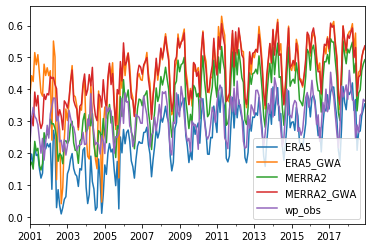

In [25]:
cf_USAIm.plot()

In [26]:
# Analyse
stats_USAIm = pd.DataFrame({'ERA5':stats(cf_USAIm.ERA5,cf_USAIm.wp_obs,False),
                           'ERA5_GWA':stats(cf_USAIm.ERA5_GWA,cf_USAIm.wp_obs,False),
                           'MERRA2':stats(cf_USAIm.MERRA2,cf_USAIm.wp_obs,False),
                           'MERRA2_GWA':stats(cf_USAIm.MERRA2_GWA,cf_USAIm.wp_obs,False),
                           'obs':[np.nan,np.nan,np.nan,cf_USAIm.wp_obs.mean()]},
                          index = ['cor','rmse','mbe','avg'])
stats_USAIm_r = pd.DataFrame({'ERA5':stats(cf_USAIm.ERA5,cf_USAIm.wp_obs),
                             'ERA5_GWA':stats(cf_USAIm.ERA5_GWA,cf_USAIm.wp_obs),
                             'MERRA2':stats(cf_USAIm.MERRA2,cf_USAIm.wp_obs),
                             'MERRA2_GWA':stats(cf_USAIm.MERRA2_GWA,cf_USAIm.wp_obs),
                             'obs':[np.nan,np.nan,np.nan,round(cf_USAIm.wp_obs.mean(),2)]},
                            index = ['cor','rmse','mbe','avg'])
# save statistical results
stats_USAIm.to_csv(results_path+'/stats_USAm_IRENA2.csv')
stats_USAIm_r.to_csv(results_path+'/stats_USAm_IRENA2r.csv',sep=';')

# 2. only divide observed by IRENA

In [33]:
cf_USAUm = pd.concat([wp_USAm.div(cap_usaUm,axis=0),
                      prod_USAm.resample('M').sum().wp_obs*10**6/(cap_usaIm*10**3)],axis=1).dropna()[1:]
cf_USAUm.columns = cf_USAIm.columns

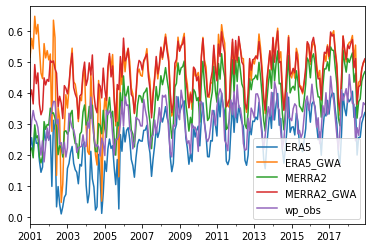

In [35]:
cf_USAUm.plot()

In [41]:
# Analyse
stats_USAUm = pd.DataFrame({'ERA5':stats(cf_USAUm.ERA5,cf_USAUm.wp_obs,False),
                           'ERA5_GWA':stats(cf_USAUm.ERA5_GWA,cf_USAUm.wp_obs,False),
                           'MERRA2':stats(cf_USAUm.MERRA2,cf_USAUm.wp_obs,False),
                           'MERRA2_GWA':stats(cf_USAUm.MERRA2_GWA,cf_USAUm.wp_obs,False),
                           'obs':[np.nan,np.nan,np.nan,cf_USAUm.wp_obs.mean()]},
                          index = ['cor','rmse','mbe','avg'])
stats_USAUm_r = pd.DataFrame({'ERA5':stats(cf_USAUm.ERA5,cf_USAUm.wp_obs),
                             'ERA5_GWA':stats(cf_USAUm.ERA5_GWA,cf_USAUm.wp_obs),
                             'MERRA2':stats(cf_USAUm.MERRA2,cf_USAUm.wp_obs),
                             'MERRA2_GWA':stats(cf_USAUm.MERRA2_GWA,cf_USAUm.wp_obs),
                             'obs':[np.nan,np.nan,np.nan,round(cf_USAUm.wp_obs.mean(),2)]},
                            index = ['cor','rmse','mbe','avg'])
# save statistical results
stats_USAUm.to_csv(results_path+'/stats_USAm_IRENA1.csv')
stats_USAUm_r.to_csv(results_path+'/stats_USAm_IRENA1r.csv',sep=';')

In [96]:
dat = pd.concat([stats_USAUm_r,stats_USAIm_r],axis=0,keys = ['USWTDB','IRENA']).unstack().unstack().reset_index()
dat.columns = ['rea','par','cap','value']

the correlation seems higher and the errors a bit lower if only IRENA data are used for deriving capacity factors

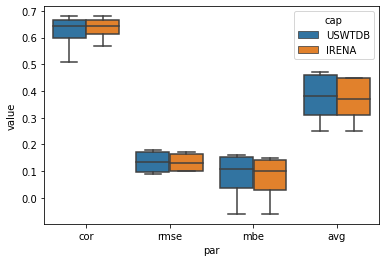

In [100]:
sns.boxplot(x='par',y = 'value',hue='cap',data=dat)

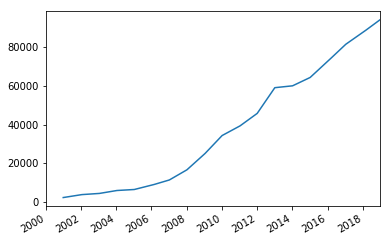

In [7]:
cap_usa.plot()

C:\Users\KatharinaG\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


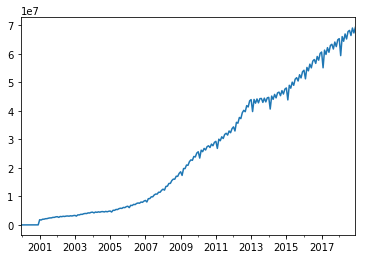

In [9]:
cap_usam.plot()